In [1]:
from os.path import expanduser, exists
from zipfile import ZipFile
import pickle

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.models import Model
from keras.layers import Input, Embedding, GRU, LSTM, Dense, BatchNormalization, Dropout
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow.keras

Using TensorFlow backend.


In [2]:
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'
EMBEDDING_DIM = 300

train_file = 'data/raw/gap-coreference/gap-development.tsv'
dev_file = 'data/raw/gap-coreference/gap-validation.tsv'
test_file = 'data/raw/gap-coreference/gap-test.tsv'

In [3]:
# Download and process GloVe embeddings
if not exists(KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)

In [4]:
# Create embedding index
def get_embeddings():
    embeddings_index = {}
    file = KERAS_DATASETS_DIR + GLOVE_FILE

    with open(file, encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding

    print('Word embeddings: %d' % len(embeddings_index))
    return embeddings_index


# Prepare word embedding matrix
def get_embedding_matrix(embeddings_index, word_index, max_nb_words):
    nb_words = min(max_nb_words, len(word_index))
    word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > max_nb_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            word_embedding_matrix[i] = embedding_vector

    print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))
    return word_embedding_matrix, nb_words

In [5]:
# Prepare training data tensors
def pad_sentences(gap_word_sequences, coref, maxlen):
    gap_text = pad_sequences(gap_word_sequences, maxlen=maxlen)
    labels = np.array(coref, dtype=int)
    print('Shape of text data tensor:', gap_text.shape)
    print('Shape of label tensor:', labels.shape)
    return gap_text, labels

#Initialize embedding matrix. If it exists, load it, otherwise create it
def init_embeddings(w_index, max_nb_words):
    cache_filename = "embedding_matrix.npy"

    if exists(cache_filename):
        word_embedding_matrix = np.load(cache_filename)
        word_embedding_matrix = word_embedding_matrix[0]
    else:
        # Prepare embedding matrix to be used in Embedding Layer
        embeddings_index = get_embeddings()
        word_embedding_matrix = get_embedding_matrix(embeddings_index, w_index, max_nb_words)
        np.save(cache_filename, word_embedding_matrix)
    return word_embedding_matrix

#Create and save tokenizer
def create_tokenizer(gap_text):
    print('Creating tokenizer...')
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(gap_text)
    with open('tokenizer.pickle', "wb") as output_file:
        pickle.dump(tokenizer, output_file)

#Tokenize text and create word index
def tokenize_text(gap_text):
    # load tokenizer
    if not exists('tokenizer.pickle'):
        create_tokenizer(gap_text)
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    gap_word_sequences = tokenizer.texts_to_sequences(gap_text)
    word_index = tokenizer.word_index
    print("Words in index: %d" % len(word_index))

    return gap_word_sequences, word_index

def prepare_glove(maxlen, gap_text, coref):
    gap_word_sequences, w_index = tokenize_text(gap_text)
    gap, labels = pad_sentences(gap_word_sequences, coref, maxlen)
    return gap, labels, w_index

In [6]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

def words_between(x, num_words=30):
    all_before = x[0][:x[1]].split(' ')
    all_after = x[0][x[1]:].split(' ')
    words_before =  " ".join(all_before[-num_words:])
    words_after =  " ".join(all_after[:num_words+1])
    return words_before + words_after

def read_dataset(filename):
    gap_df = pd.read_csv(filename, sep='\t')
    # take the text as it is
    # gap_text = pd.Series(gap_df['Text'].tolist())
    
    #Take a window of n words (n/2 before the pronoun, n/2 after the promnoun)
    gap_df['NN-input'] = gap_df[['Text', 'Pronoun-offset']].apply(words_between, axis=1)
    gap_text = pd.Series(gap_df['NN-input'].tolist())

    labels = gap_df.apply(_row_to_y, axis=1)
    return gap_text, labels

def prepare_dataset(filename, maxlen, max_nb_words, train=0):
    gap_text, labels = read_dataset(filename)
    X, y, w_index = prepare_glove(maxlen, gap_text, labels)
    if train == 0:
        word_embedding_matrix = init_embeddings(w_index, max_nb_words)
        return X, y, word_embedding_matrix
    else:
        return X, y

In [7]:
def create_model(word_embedding_matrix, n_hidden, dropout, maxlen, lr):
    in_dim, out_dim = word_embedding_matrix.shape
    
    gap_input = Input(name='gap', shape=(maxlen,))
    
    embedding_layer = Embedding(in_dim,
                                out_dim,
                                weights=[word_embedding_matrix],
                                input_length=maxlen,
                                trainable=False)
    embedding_ = embedding_layer(gap_input)
    lstm_layer = LSTM(n_hidden, kernel_initializer='glorot_uniform',
                       bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001))

    lstm_output = lstm_layer(embedding_)
    
    output_ = Dense(n_hidden, activation='relu')(lstm_output)
    output_ = Dropout(dropout)(output_)
    output_ = BatchNormalization()(output_)
    output_ = Dense(n_hidden, activation='relu')(output_)
    output_ = Dropout(dropout)(output_)
    output_ = BatchNormalization()(output_)
    
    output = Dense(3, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001),
                   bias_regularizer=regularizers.l2(0.0001))(output_)
    
    net = Model(gap_input, [output])

    net.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy',
                metrics=['categorical_crossentropy', 'accuracy'])
    return net

def evaluate_best_model(model, gap_test, y_test, filepath):
    model.load_weights(filepath)

    scores = model.evaluate([gap_test], y_test, verbose=0, batch_size=4)
    loss = scores[1]
    accuracy = scores[2]
    return loss, accuracy

In [8]:
maxlen = 100
max_nb_words = 25000

gap_train, y_train, word_embedding_matrix = prepare_dataset(train_file, maxlen, max_nb_words, train=0)
gap_dev, y_dev = prepare_dataset(dev_file, maxlen, max_nb_words, train=1)
gap_test, y_test = prepare_dataset(test_file, maxlen, max_nb_words, train=1)

y_train = to_categorical(y_train, num_classes=3)
y_dev = to_categorical(y_dev, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

Words in index: 22236
Shape of text data tensor: (2000, 100)
Shape of label tensor: (2000,)
Words in index: 22236
Shape of text data tensor: (454, 100)
Shape of label tensor: (454,)
Words in index: 22236
Shape of text data tensor: (2000, 100)
Shape of label tensor: (2000,)


In [9]:
gap_train

array([[    0,     0,     0, ...,     8,   141,  2307],
       [    0,     0,     0, ...,     2,  9980,  9981],
       [    0,     0,     0, ...,  6409,    13,     1],
       ...,
       [    0,     0,     0, ...,   373,  4103, 22223],
       [    0,     0,     0, ...,   277, 22234,   165],
       [    0,     0,     0, ...,     5,     8,   336]], dtype=int32)

In [10]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [11]:
BATCH_SIZE = 1
NB_EPOCH = 20
N_HIDDEN = 300
DROPOUT = 0.1
LR = 1e-3
MAXLEN = 100
NUM_WORDS = 30

filename = "models/weights.best.lstm.hdf5"
hist = History()

net = create_model(word_embedding_matrix, N_HIDDEN, DROPOUT, MAXLEN, LR)
net.summary()

callbacks = [ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min'),
             EarlyStopping(monitor='val_loss', patience=2)]

# Start training
hist = net.fit([gap_train], y_train,
               validation_data=([gap_dev], y_dev),
               batch_size=BATCH_SIZE, nb_epoch=NB_EPOCH, shuffle=True, callbacks=callbacks)

# compute final accuracy on training and test sets
scores = net.evaluate([gap_test], y_test)
print("\n%s: %.2f, %s: %.2f%%" % (net.metrics_names[1], scores[1], net.metrics_names[2], scores[2]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gap (InputLayer)             (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          6671100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1

/anaconda3/envs/coref/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2000 samples, validate on 454 samples
Epoch 1/20
2000/2000 [==============================] - 169s 85ms/step - loss: 0.9597 - categorical_crossentropy: 0.9583 - acc: 0.4450 - val_loss: 1.0195 - val_categorical_crossentropy: 1.0186 - val_acc: 0.4515
Epoch 2/20
2000/2000 [==============================] - 171s 85ms/step - loss: 0.9540 - categorical_crossentropy: 0.9532 - acc: 0.4530 - val_loss: 0.9977 - val_categorical_crossentropy: 0.9970 - val_acc: 0.4515
Epoch 3/20
2000/2000 [==============================] - 162s 81ms/step - loss: 0.9545 - categorical_crossentropy: 0.9538 - acc: 0.4415 - val_loss: 0.9969 - val_categorical_crossentropy: 0.9963 - val_acc: 0.4515
Epoch 4/20
2000/2000 [==============================] - 163s 81ms/step - loss: 0.9529 - categorical_crossentropy: 0.9522 - acc: 0.4485 - val_loss: 1.0000 - val_categorical_crossentropy: 0.9993 - val_acc: 0.4515
Epoch 5/20
2000/2000 [==============================] - 3s 1ms/step

categorical_crossentropy: 0.97, acc: 45.

In [12]:
test_loss, test_acc = evaluate_best_model(net, gap_test, y_test, filename)
print('Evaluation: loss = {0:.4f}, accuracy = {1:.2f}%'.format(test_loss, test_acc * 100))

Evaluation: loss = 0.9725, accuracy = 42.75%


In [13]:
with mlflow.start_run():
   # log metrics
    mlflow.log_metric("categorical_crossentropy", test_loss)
    mlflow.log_metric("accuracy", test_acc)
    
    #log params
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("nb_epoch", NB_EPOCH)
    mlflow.log_param("n_hidden", N_HIDDEN)
    mlflow.log_param("dropout", DROPOUT)
    mlflow.log_param("lr", LR)
    mlflow.log_param("maxlen", MAXLEN)
    mlflow.log_param("num_words", NUM_WORDS)
    
    #log model
    mlflow.keras.log_model(net, "models")

**NOTE**: setup MLflow to track parameters and experiments. Some initial results:

- Best model with first 100 words: Evaluation: loss = 0.9742, accuracy = 45.65%


- Window of 25 words: Evaluation: loss = 0.9786, accuracy = 44.00%


- Window of 30 words: Evaluation: loss = 0.9670, accuracy = 48.15%
- Window of 30 words: Evaluation: loss = 0.9892, accuracy = 45.70%
- Window of 30 words: Evaluation: loss = 0.9735, accuracy = 46.75%
- Window of 30 words: Evaluation: loss = 0.9673, accuracy = 42.75% (dropout = 0.3)


- Window of 35 words: Evaluation: loss = 0.9925, accuracy = 44.60%
- Window of 35 words: Evaluation: loss = 0.9835, accuracy = 43.55%


- Window of 40 words: Evaluation: loss = 0.9815, accuracy = 44.95%
- Window of 40 words: Evaluation: loss = 0.9794, accuracy = 48.30%
- Window of 40 words: Evaluation: loss = 0.9716, accuracy = 42.85% (dropout = 0.3)

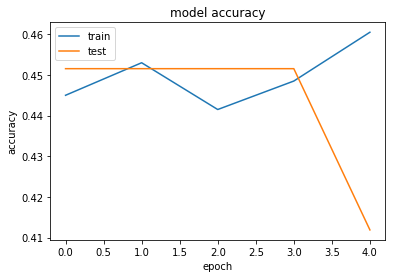

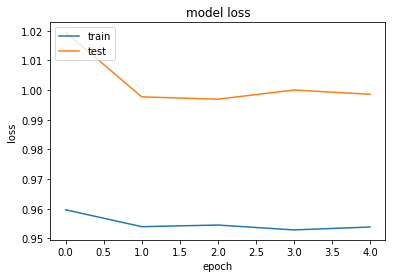

In [14]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()